# Clustering with PCA in Julia

Following is the data of single-cell fluorescent analysis for 2 E.coli strains, named as WT and DTolC. Cells were treated with 2 fluorescent dyes, DiSC and HT. In order to see if there's any distinction between WT and DTolC after treatment, I will perform PCA analysis on this dataset

In [50]:
# import libraries
using CSV
using DataFrames
using Plots
using MultivariateStats
using MLBase
using MLLabelUtils
using Lathe
using Random
using IJulia
using Statistics
using StatsPlots

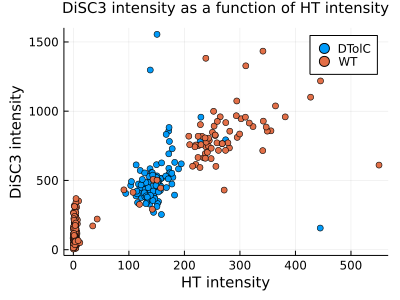

In [52]:
#load file into dataframe
df = DataFrame(CSV.File("H:\\My Drive\\R Python\\Dropbox\\DiSC3 HT 50uM CCCP.csv"))
gr(size=(400,300))
#Scatter plots to visualize data
@df df scatter(:HT_Intensity,
               :DiSC_Intensity,
               group=:Genotype,
               legend = :topright,
               title = "DiSC3 intensity as a function of HT intensity",
               titlefont=font(10),
               xlabel="HT intensity",
               ylabel="DiSC3 intensity",
               guidefontsize=10
            )



In [53]:
# Normalize data
# Calc mean and std
HT_mean=mean(df.HT_Intensity)
HT_std=std(df.HT_Intensity)
DiSC_mean=mean(df.DiSC_Intensity)
DiSC_std=std(df.DiSC_Intensity)
# Apply standard scaler z=(x-u)/s
transform!(df, :HT_Intensity => (x -> (x .- HT_mean)/HT_std) => :HT_Intensity1)
transform!(df, :DiSC_Intensity => (x -> (x .- DiSC_mean)/DiSC_std) => :DiSC_Intensity1)

,Genotype,DiSC_Intensity,HT_Intensity,HT_Intensity1,DiSC_Intensity1
,String,Float64,Float64,Float64,Float64
1,WT,743.863,238.558,1.12219,1.08353
2,WT,260.821,2.81749,-0.955943,-0.469459
3,WT,194.642,1.46253,-0.967887,-0.682225
4,WT,615.77,220.52,0.963184,0.671705
5,WT,186.759,7.15843,-0.917676,-0.707569
6,WT,256.886,2.32575,-0.960278,-0.482109
7,WT,750.173,243.019,1.16152,1.10381
8,WT,292.074,142.153,0.272348,-0.36898
9,WT,663.336,234.746,1.0886,0.824632


In [54]:
#Convert label from string to integer
df[!,"Genotype"]=convertlabel(LabelEnc.Indices{Int},df[!,"Genotype"])

321-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 2
 2
 2
 2
 2
 2
 2
 2
 2

In [55]:
# Convert dataframe to matrix with encoded labels
data=Matrix(df[:,[:Genotype,:HT_Intensity1,:DiSC_Intensity1]])


321×3 Matrix{Float64}:
 1.0   1.12219     1.08353
 1.0  -0.955943   -0.469459
 1.0  -0.967887   -0.682225
 1.0   0.963184    0.671705
 1.0  -0.917676   -0.707569
 1.0  -0.960278   -0.482109
 1.0   1.16152     1.10381
 1.0   0.272348   -0.36898
 1.0   1.0886      0.824632
 1.0   1.62047     1.29955
 ⋮                
 2.0   0.151282    0.474144
 2.0   0.192631   -0.0874133
 2.0   0.0347656  -0.0112147
 2.0  -0.914459   -1.14423
 2.0   0.0942431   0.196488
 2.0   0.113443    0.322608
 2.0   0.0268932   0.0516239
 2.0   0.538379    1.5291
 2.0   0.543846    1.20526

In [57]:
# PCA requires columns in input as case data (in this case, DiSC and HT intensities for each cell) 
# So I will fit transposed matrix data' with PCA, out dimension is 2 since I expected 2 clusters from the scatter plot
p = fit(PCA,data',maxoutdim=2)

PCA(indim = 3, outdim = 2, principalratio = 0.9428784557436521)

In [58]:
# Obtain projection matrix
P = projection(p)

3×2 Matrix{Float64}:
 0.0911538   0.992193
 0.704425   -0.0038346
 0.703901   -0.12465

In [59]:
# Transform data with projection matrix
Y = MultivariateStats.transform(p, data')

2×321 Matrix{Float64}:
  1.52253   -1.03451   -1.19269    1.12064   …  0.115768  1.51607   1.29197
 -0.473186  -0.271639  -0.245072  -0.421243     0.651833  0.465705  0.506051

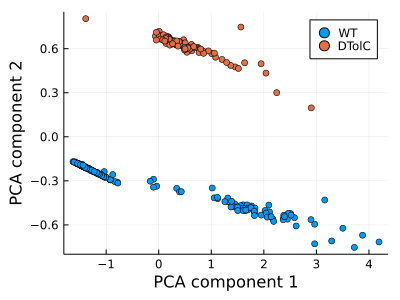

In [60]:
# Visualize transformed data
P1=(Y[1,df.Genotype.==1],Y[2,df.Genotype.==1])
P2=(Y[1,df.Genotype.==2],Y[2,df.Genotype.==2])
p1=plot(P1,label="WT",seriestype = :scatter,
        xlabel="PCA component 1",
        ylabel="PCA component 2")
p2=plot!(P2,label="DTolC",seriestype=:scatter)


From this plot, we can see clearly 2 clusters representing WT and DTolC. This means WT and DTolC reacted differently when treated with DiSC and HT.